In [1]:
#!pip install /pstore/home/shetabs1/code/scifai/

In [2]:
import scifai
import matplotlib.pyplot as plt
import scifai.ml.features as features
from scifai.ml.feature_selection import AutoFeatureSelection
from scifai.ml.feature_extractor import AmnisData
from scifai.ml.segmentation import segment_all_channels
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import h5py
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from scifai.utils import list_of_dict_to_dict
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(estimator, X, y_true, plot = True ): 
    y_pred = estimator.predict(X)
    print(classification_report(y_true, y_pred))
    print(classification_report_imbalanced(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true,cmap = "Greys", xticks_rotation='vertical')
    

In [5]:
data_path = "/pstore/data/DS4/Cell_Cycle_Reconstruction/"

feature_extractor = FeatureUnion([
                                ("MaskBasedFeatures", features.MaskBasedFeatures()), 
                                ("GLCMFeatures", features.GLCMFeatures()),  
                                ("GradientRMS", features.GradientRMS()),  
                                ("BackgroundMean", features.BackgroundMean()),  
                                ("CellShape", features.CellShape()),  
                                ("Collocalization", features.Collocalization())
                                     ],
                                n_jobs = -1)

In [6]:
%time

amnis_data = AmnisData(data_path, feature_extractor)

  0%|          | 0/32266 [00:00<?, ?it/s]

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 17.9 µs
Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 32266/32266 [00:21<00:00, 1482.08it/s]


...metadata prepration ended.


In [7]:
amnis_data.extract_features_for_all_samples()

100%|██████████| 32266/32266 [15:27<00:00, 34.77it/s]


In [8]:
amnis_data.df_features = amnis_data.df_features.fillna(0.)
amnis_data.df_features = amnis_data.df_features.loc[:, amnis_data.df_features.std() > 0.]

In [9]:
amnis_data.df_features.memory_usage(index=True).sum()/1e9

0.044140016

In [10]:
index_train , index_test = train_test_split(amnis_data.metadata.index, stratify = amnis_data.metadata["label"])

In [21]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler,ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

pipeline = Pipeline( steps = [
            ("MinMaxScaler",MinMaxScaler()),
            ("AutoFeatureSelection",AutoFeatureSelection(top_k = 10,verbose=True)),
            ("SMOTE",SMOTE(n_jobs = -1)),
            ("RandomForestClassifier",RandomForestClassifier(n_jobs = -1 ) )
] ,verbose=True )
                            
pipeline.fit(amnis_data.df_features.loc[index_train,:],  
             amnis_data.metadata.loc[index_train, "label"])

[Pipeline] ...... (step 1 of 4) Processing MinMaxScaler, total=   0.1s
Step 1: drop highly correlated features
From 171 initial features Selected (correlated): 169
Step 2: wrapper methods
Calculating SVC
Calculating random forest
Calculating l1 logistic regression
Calculating l2 logistic
Calculating xgb
From 171 initial features Selected (multicolinear): 51
Step 3: clustering over correlation of features
From 171 initial features Selected (uncorrelated): 16
[Pipeline]  (step 2 of 4) Processing AutoFeatureSelection, total= 6.7min
[Pipeline] ............. (step 3 of 4) Processing SMOTE, total=   2.6s
[Pipeline]  (step 4 of 4) Processing RandomForestClassifier, total=   1.5s


Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('AutoFeatureSelection',
                 AutoFeatureSelection(top_k=10, verbose=True)),
                ('SMOTE', SMOTE(n_jobs=-1)),
                ('RandomForestClassifier', RandomForestClassifier(n_jobs=-1))],
         verbose=True)

In [22]:
selected_features = pipeline.steps[1][1].selected_features
selected_feature_names = amnis_data.df_features.columns[selected_features]

              precision    recall  f1-score   support

    Anaphase       0.00      0.00      0.00         4
          G1       0.84      0.85      0.84      3583
          G2       0.75      0.74      0.74      2150
   Metaphase       0.09      0.06      0.07        17
    Prophase       0.35      0.35      0.35       152
           S       0.57      0.58      0.58      2154
   Telophase       0.00      0.00      0.00         7

    accuracy                           0.73      8067
   macro avg       0.37      0.37      0.37      8067
weighted avg       0.73      0.73      0.73      8067

                   pre       rec       spe        f1       geo       iba       sup

   Anaphase       0.00      0.00      1.00      0.00      0.00      0.00         4
         G1       0.84      0.85      0.87      0.84      0.86      0.74      3583
         G2       0.75      0.74      0.91      0.74      0.82      0.66      2150
  Metaphase       0.09      0.06      1.00      0.07      0.24      0.

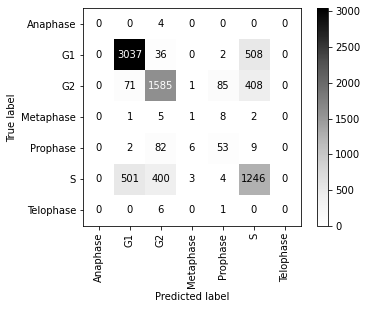

In [23]:
classification_complete_report(pipeline, 
                               amnis_data.df_features.loc[index_test,:], 
                               amnis_data.metadata.loc[index_test, "label"])

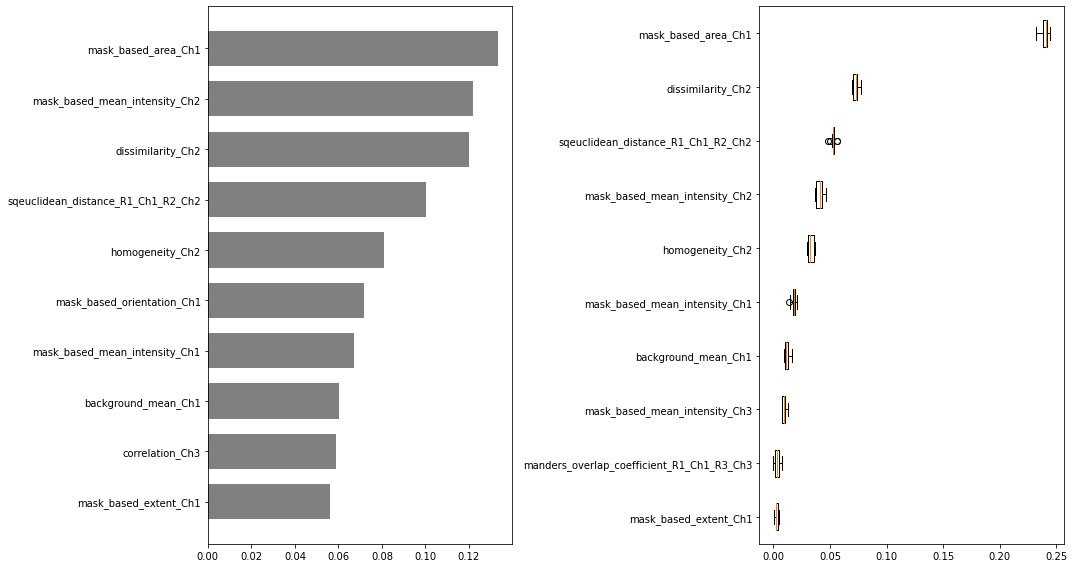

In [24]:

from sklearn.inspection import permutation_importance




fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(pipeline.steps[3][1].feature_importances_)[-10:]

tree_indices = np.arange(0, 10) + 0.5

ax1.barh(tree_indices, 
         pipeline.steps[3][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(amnis_data.df_features.columns[selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(pipeline, 
                                amnis_data.df_features.loc[index_test,:],  
                                amnis_data.metadata.loc[index_test, "label"], n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-10:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=amnis_data.df_features.columns.values[perm_sorted_idx])

fig.tight_layout()

In [25]:

channel_importance_xgb = {"Ch1" : 0., "Ch2" : 0., "Ch3": 0.}

for i,f in enumerate(selected_feature_names):
    value = pipeline.steps[3][1].feature_importances_[i]
    if "Ch1" in f:
        channel_importance_xgb["Ch1"] = channel_importance_xgb["Ch1"] + value
    elif "Ch2" in f:
        channel_importance_xgb["Ch2"] = channel_importance_xgb["Ch2"] + value
    elif "Ch3" in f:
        channel_importance_xgb["Ch3"] = channel_importance_xgb["Ch3"] + value


channel_importance_permutation = {"Ch1" : 0., "Ch2" : 0., "Ch3": 0.}

for i,f in enumerate(amnis_data.df_features.columns):
    value = result['importances_mean'][i]
    if "Ch1" in f:
        channel_importance_permutation["Ch1"] = channel_importance_permutation["Ch1"] + value
    elif "Ch2" in f:
        channel_importance_permutation["Ch2"] = channel_importance_permutation["Ch2"] + value
    elif "Ch3" in f:
        channel_importance_permutation["Ch3"] = channel_importance_permutation["Ch3"] + value


Text(0.5, 1.0, 'Channel importance')

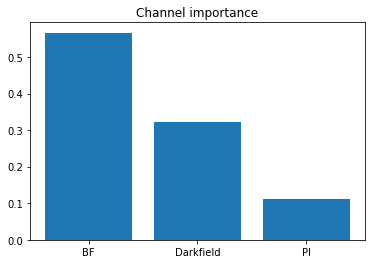

In [26]:
plt.bar(["BF", "Darkfield", "PI"], channel_importance_xgb.values())
plt.title("Channel importance")

Text(0.5, 1.0, 'Channel importance')

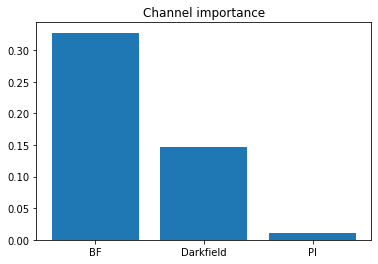

In [27]:
plt.bar(["BF", "Darkfield", "PI"], channel_importance_permutation.values())
plt.title("Channel importance")